In [45]:
import cv2 as cv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [46]:
model_corn = tf.keras.models.load_model('saved_models/model_corn.keras')
model_potato = tf.keras.models.load_model('saved_models/model_potato.keras')
model_rice = tf.keras.models.load_model('saved_models/model_rice.keras')
model_wheat = tf.keras.models.load_model('saved_models/model_wheat.keras')
crop_models = {
    'corn': model_corn,
    'potato': model_potato,
    'rice': model_rice,
    'wheat': model_wheat
}
IMAGE_SIZE = 256

In [47]:
def sliding_window(image, step_size, window_size):
    patches = []
    locations = []
    
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            patch = image[y:y + window_size[1], x:x + window_size[0]]
            patches.append(patch)
            locations.append((x, y))
    
    # Handle any remaining partial patches
    for y in range(0, image.shape[0], step_size):
        if y + window_size[1] > image.shape[0]:
            for x in range(0, image.shape[1], step_size):
                if x + window_size[0] > image.shape[1]:
                    patch = image[y:image.shape[0], x:image.shape[1]]
                    patch = cv.copyMakeBorder(patch, 0, window_size[1] - patch.shape[0], 0, window_size[0] - patch.shape[1], cv.BORDER_CONSTANT, value=(0, 0, 0))
                    patches.append(patch)
                    locations.append((x, y))

    return patches, locations

In [48]:
def classify_patches(image, model, step_size, window_size, threshold=0.5):
    patches, locations = sliding_window(image, step_size, window_size)
    heatmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)

    for i, patch in enumerate(patches):
        patch = cv.resize(patch, (IMAGE_SIZE, IMAGE_SIZE))
        patch = np.expand_dims(patch, axis=0)  # Add batch dimension
        patch = patch / 255.0  # Normalize

        prediction = model.predict(patch)[0]
        if np.max(prediction) > threshold:  # Adjust threshold as needed
            x, y = locations[i]
            heatmap[y:y + window_size[1], x:x + window_size[0]] += np.max(prediction)

    heatmap = heatmap / np.max(heatmap)  # Normalize heatmap to range [0, 1]
    return heatmap

In [49]:
def draw_bounding_boxes(image, heatmap, threshold=0.5):
    result_image = image.copy()
    boxes = []
    contours, _ = cv.findContours((heatmap > threshold).astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        x, y, w, h = cv.boundingRect(contour)
        cv.rectangle(result_image, (x, y), (x + w, y + h), (0, 0, 255), 2)
        boxes.append((x, y, w, h))
    
    return result_image, boxes

In [50]:
def process_mapped_picture(image_path, crop):
    image = cv.imread(image_path)
    # Example dynamic segmentation size, adapt based on resolution
    window_size = (256, 256)  
    step_size = 128  # 50% overlap, adjust as needed
    heatmap = classify_patches(image, crop_models[crop], step_size, window_size)
    result_image, boxes = draw_bounding_boxes(image, heatmap)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv.cvtColor(result_image, cv.COLOR_BGR2RGB))
    plt.title("Detected Disease Areas on Mapped Picture")
    plt.axis('off')
    plt.show()

    return result_image, boxes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


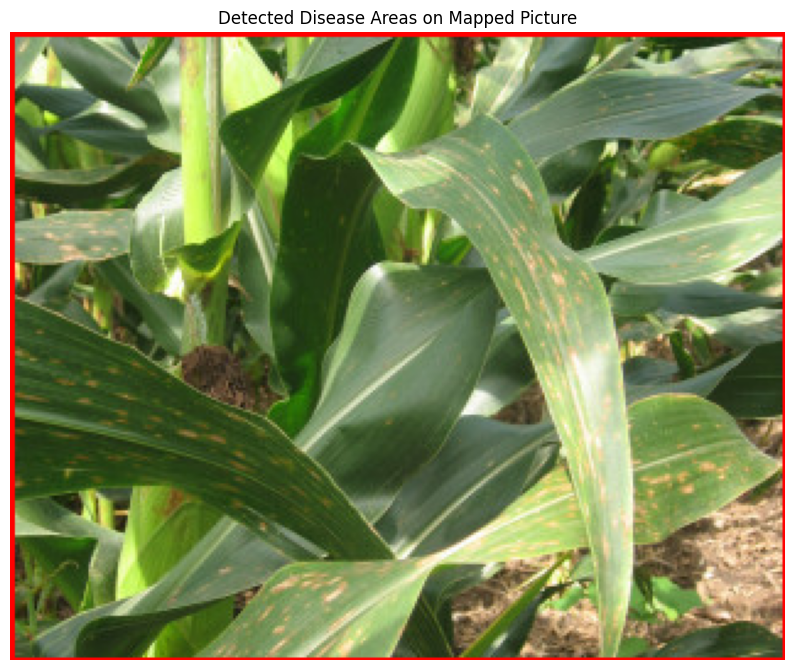

[(0, 0, 316, 256)]

In [52]:
mapped_image_path = 'field_panorama.jpg'
crop = 'corn'
result_image, boxes = process_mapped_picture(mapped_image_path, crop)
cv.imwrite('marked_map.png',result_image)
boxes